In [1]:
import requests
import torch
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
from diffusers import StableDiffusionImg2ImgPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\mgphy\Anaconda3\envs\genai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


In [3]:
url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

prompt = "A fantasy landscape, trending on artstation"

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
# images[0].save("fantasy_landscape.png")

c:\Users\mgphy\Anaconda3\envs\genai\lib\site-packages\diffusers\models\attention_processor.py:1279: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 37/37 [00:07<00:00,  4.70it/s]


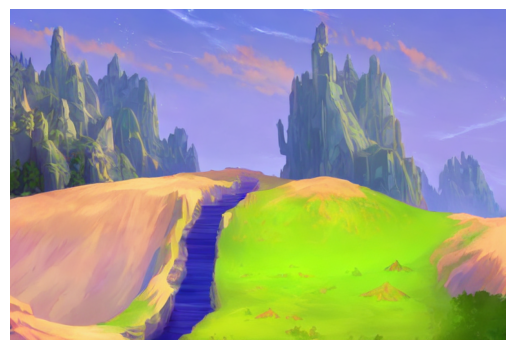

In [4]:
# Assuming you have a list of images called 'images'
for image in images:
    plt.imshow(image)
    plt.axis('off')
    plt.show()

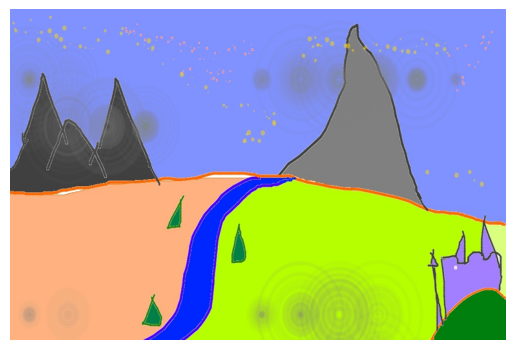

In [4]:
plt.imshow(init_image)
plt.axis('off')
plt.show()

In [5]:
pipe

StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Useful website: https://huggingface.co/blog/stable_diffusion

Inside the pipeline there's a VAE and a Unet.

Things to do:
- Find a dataset of amateur pics and retrieve their embeds
- Find a dataset of pro pics and retrieve their embeds
- In theory, the prompt shouldn't affect this part if I use the embeddings produced by VAE's encoder, because that prompt will influence the Unet later
- Check if there is an appreciable difference between the embeddings of the two datasets:
    - either by performing a PCA and ideally find a PC that corresponds to an esthetic quality
    - or by classifying the embeddings: if a classifier is able to learn the distinction then there's a distinction and that's also enough for our purposes

Here below I find the embedding produced by the VAE's encoder. Maybe I need to use the Unet embedding?

In [5]:
import torchvision.transforms as transforms
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import retrieve_latents

transform = transforms.ToTensor()
tensor_image = transform(init_image).to(device=device, dtype=torch.half).unsqueeze(0)

latents = retrieve_latents(pipe.vae.encode(tensor_image))

In [7]:
# shape (batch, latent_channels, width, height)

latents.shape

torch.Size([1, 4, 64, 96])

encoder -> unet -> decoder

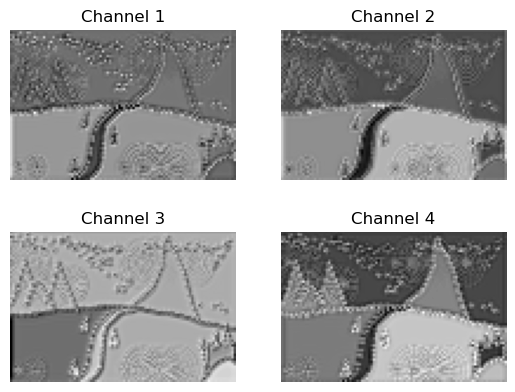

In [6]:
# Assuming latents is a tensor with shape (batch, latent_channels, width, height)
fig, axs = plt.subplots(2, 2)

# Plotting the four channels separately
for i, ax in enumerate(axs.flat):
    ax.imshow(latents[0, i].cpu().detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Channel {i+1}')

plt.show()

Unet embedding

In [ ]:
print(pipe.unet)

In [7]:
latent = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5, output_type='latent').images

100%|██████████| 37/37 [00:08<00:00,  4.52it/s]


In [16]:
latent.shape

torch.Size([1, 4, 64, 96])

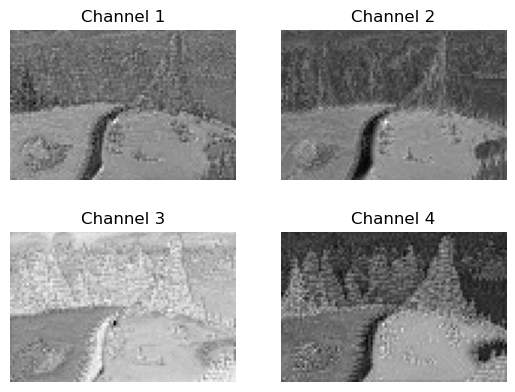

In [8]:
# Assuming latents is a tensor with shape (batch, latent_channels, width, height)
fig, axs = plt.subplots(2, 2)

# Plotting the four channels separately
for i, ax in enumerate(axs.flat):
    ax.imshow(latent[0, i].cpu().detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Channel {i+1}')

plt.show()

This is the Unet output, before being decoded by VAE's decoder

AVA dataset downloader: https://github.com/ylogx/aesthetics (this dataset is now copyrighted)

## AADB

Alternative dataset from [this paper](https://arxiv.org/abs/1606.01621)

Download full resolution dataset from here: https://drive.usercontent.google.com/download?id=1Viswtzb77vqqaaICAQz9iuZ8OEYCu6-_&export=download&authuser=0

Description: https://ics.uci.edu/~skong2/aesthetics.html
- 10 000 images
- all of them are real photographies
- each image has been annoted manually by five workers with an overall esthetic score
- and eleven meaningful attributes: interesting content, object emphasis, good lightning, color harmony, vivid color, shallow depth of field, motion blur, rule of thirds, balancing element, repetition, symmetry

GitHub: https://github.com/aimerykong/deepImageAestheticsAnalysis

In [3]:
from dataset.utils import AADBDataset

dataset = AADBDataset('dataset/data/datasetImages_originalSize', 'dataset/data')

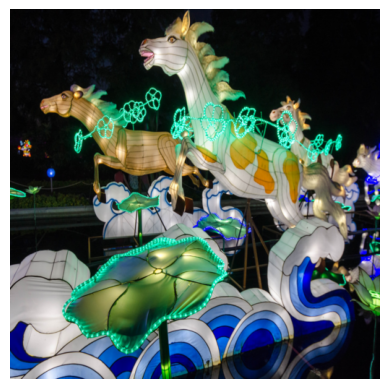

In [4]:
import matplotlib.pyplot as plt
from torchvision import transforms

pil_image = transforms.ToPILImage()(dataset[10]['image'])

# Plot the PIL image
plt.imshow(pil_image)
plt.axis('off')
plt.show()

## Encoder's embeddings

Let's perform PCA analysis on the emebeddings of the encoder. Ideally, we would find a PC that explains the variation between "pretty" and "ugly" images

In [10]:
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import retrieve_latents
from tqdm import tqdm

latents = []
scores = []

for i in tqdm(range(len(dataset))):
    image, score = dataset[i]['image'], dataset[i]['score']
    image = image.to(device=device, dtype=torch.half).unsqueeze(0)
    latent = retrieve_latents(pipe.vae.encode(image))
    latents.append(latent.detach().cpu().numpy())
    scores.append(score)

latents = np.array(latents).squeeze()
scores = np.array(scores)

100%|██████████| 9958/9958 [18:14<00:00,  9.10it/s]


In [12]:
np.save('dataset/data/saved/vae_latents.npy', latents)
np.save('dataset/data/saved/scores.npy', scores)

In [1]:
import numpy as np

latents = np.load('dataset/data/saved/vae_latents.npy')
scores = np.load('dataset/data/saved/scores.npy')

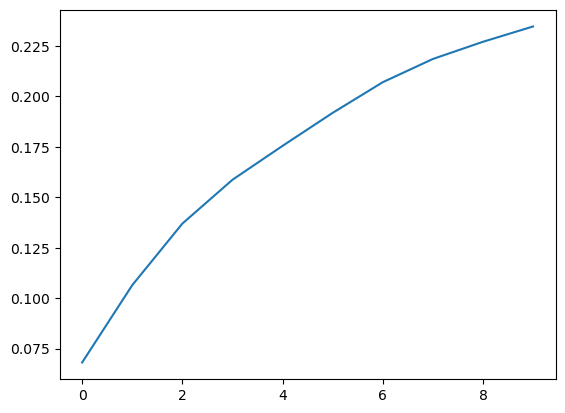

In [5]:
from sklearn.decomposition import PCA
from einops import rearrange
import matplotlib.pyplot as plt

train_size = int(len(dataset) * 0.8)
embeds = rearrange(latents, 'b c w h -> b (c w h)')
train_embeds = embeds[:train_size, :]
test_embeds = embeds[train_size:, :]

pca = PCA(n_components=10)
pca.fit(train_embeds)

embeds_pca = pca.transform(test_embeds)
test_scores = scores[train_size:]

plt.plot(np.cumsum(pca.explained_variance_ratio_))

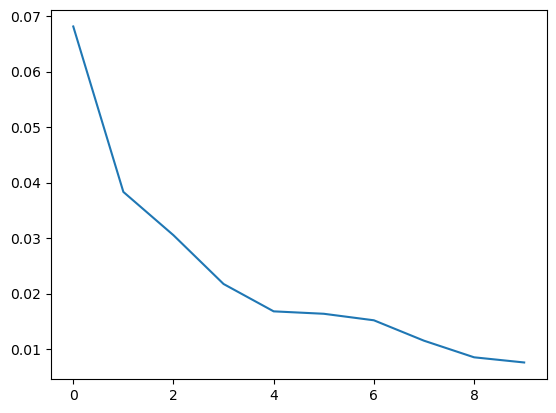

In [6]:
plt.plot(pca.explained_variance_ratio_)

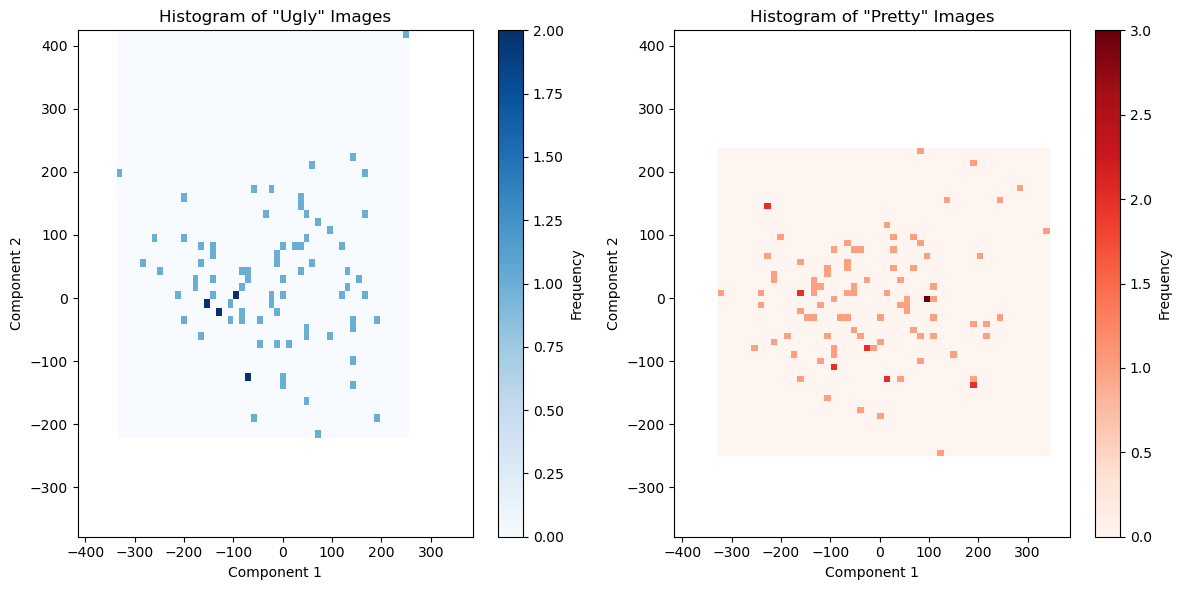

In [7]:
ugly_idx = test_scores < 0.2
pretty_idx = test_scores > 0.8

ugly_img = embeds_pca[ugly_idx]
pretty_img = embeds_pca[pretty_idx]

plt.figure(figsize=(12, 6))

# Plotting the histogram for "ugly" images
plt.subplot(1, 2, 1)
plt.hist2d(ugly_img[:, 0], ugly_img[:, 1], bins=50, cmap='Blues')
plt.colorbar(label='Frequency')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Histogram of "Ugly" Images')
plt.xlim(np.min(embeds_pca[:, 0]), np.max(embeds_pca[:, 0]))
plt.ylim(np.min(embeds_pca[:, 1]), np.max(embeds_pca[:, 1]))

# Plotting the histogram for "pretty" images
plt.subplot(1, 2, 2)
plt.hist2d(pretty_img[:, 0], pretty_img[:, 1], bins=50, cmap='Reds')
plt.colorbar(label='Frequency')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Histogram of "Pretty" Images')
plt.xlim(np.min(embeds_pca[:, 0]), np.max(embeds_pca[:, 0]))
plt.ylim(np.min(embeds_pca[:, 1]), np.max(embeds_pca[:, 1]))

plt.tight_layout()
plt.show()

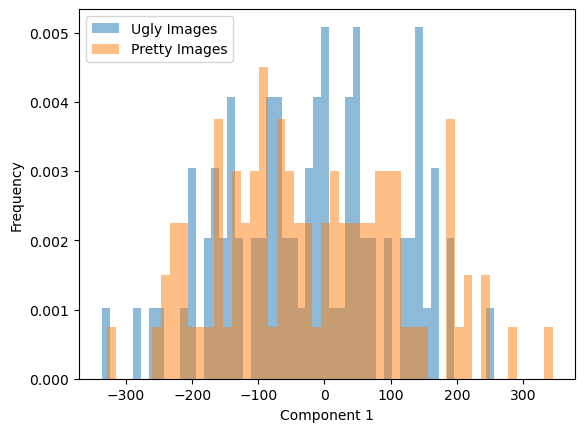

In [21]:
plt.hist(ugly_img[:, 0], density=True, bins=50, alpha=0.5, label='Ugly Images')
plt.hist(pretty_img[:, 0], density=True, bins=50, alpha=0.5, label='Pretty Images')
plt.xlabel('Component 1')
plt.ylabel('Frequency')
plt.legend()
plt.show()

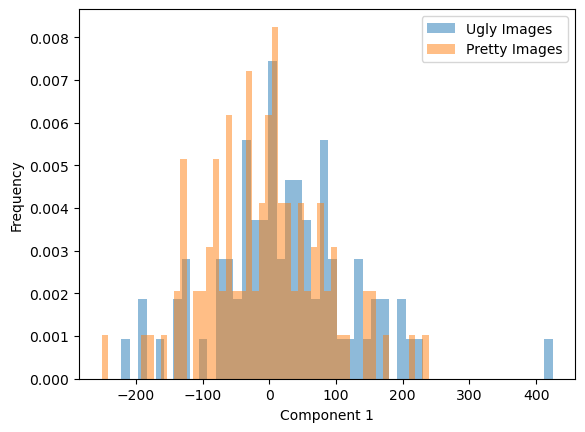

In [25]:
plt.hist(ugly_img[:, 1], density=True, bins=50, alpha=0.5, label='Ugly Images')
plt.hist(pretty_img[:, 1], density=True, bins=50, alpha=0.5, label='Pretty Images')
plt.xlabel('Component 1')
plt.ylabel('Frequency')
plt.legend()
plt.show()

It doesn't seem like there is a clear distinction at this point between pretty and ugly images.

Let's try to train a classifier:

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

pretty_idx = scores > 0.5

# Split the data into train and test sets
embeds = rearrange(latents, 'b c w h -> b (c w h)')
X_train, X_test, y_train, y_test = train_test_split(embeds, pretty_idx, test_size=0.2, random_state=42)

# Create a logistic regression classifier
classifier = LogisticRegression(max_iter=1000)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5496987951807228


As expected, the accuracy is not great, meaning that indeed at this stage the model is not able to distinguish between pretty and ugly images.

Maybe this is due to the fact that there is too much variance in the dataset. I wish I had a similar dataset divided into subjects' categories.

## Unet's embeddings

Let's try to do the same thing with the Unet embeddings, for which we need a prompt.

1. We first use an [image-to-text model](https://huggingface.co/llava-hf/llava-1.5-7b-hf) to produce short prompts for each image in the dataset.
2. Then we can
    - use the prompt as it is, or
    - modify that prompt, so that the image-to-image model produces "ugly" and "pretty" versions of each image.
3. Finally we check if there is a clear difference between pretty and ugly images at the level of Unet embeddings

In [4]:
from dataset.utils import get_prompts

prompts = get_prompts(dataset)

c:\Users\mgphy\Anaconda3\envs\genai\lib\site-packages\transformers\models\llava\configuration_llava.py:103: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 3/3 [00:16<00:00,  5.49s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\mgphy\Anaconda3\envs\genai\lib\site-packages\transformers\models\llama\modeling_llama.py:671: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


In [1]:
with open('dataset/data/aadb_prompts.txt', 'r') as file:
    lines = file.readlines()
    
prompts = [line.strip() for line in lines]

In [2]:
prompts[:5]

['Two butterflies are perched on a plant, one on the left and the other on the right.',
 'A large group of people riding bicycles down a street.',
 'A cave with a yellow light shining on the wall.',
 'A large white building with a black awning and a sign that says "Live".',
 'A large clock tower with a steeple and a weather vane on top.']

In [8]:
import numpy as np

latents = np.load('dataset/data/saved/unet_latents.npy')
scores = np.load('dataset/data/saved/scores.npy')

In [4]:
latents.shape

(3319, 4, 64, 64)

In [6]:
# Check for NaN values in latents
nan_mask = np.isnan(latents)

# Replace NaN values with random numbers
n_latents = latents.copy()
n_latents[nan_mask] = np.random.rand(np.sum(nan_mask))

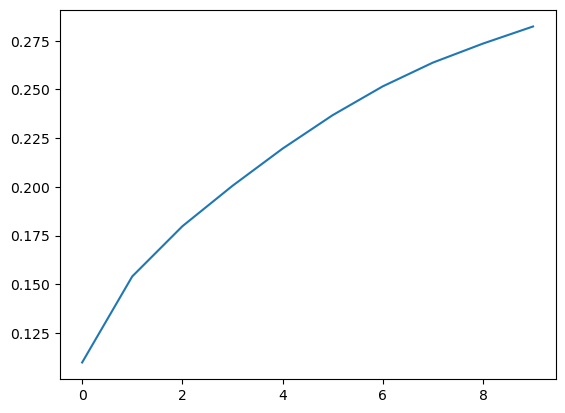

In [12]:
from sklearn.decomposition import PCA
from einops import rearrange
import matplotlib.pyplot as plt

train_size = int(len(n_latents) * 0.8)
embeds = rearrange(n_latents, 'b c w h -> b (c w h)')
train_embeds = embeds[:train_size, :]
test_embeds = embeds[train_size:, :]

pca = PCA(n_components=10)
pca.fit(train_embeds)

embeds_pca = pca.transform(test_embeds)
scores = scores[:len(latents)]
test_scores = scores[train_size:]

plt.plot(np.cumsum(pca.explained_variance_ratio_))

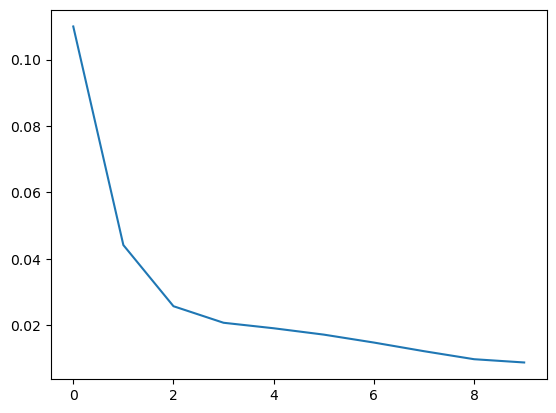

In [13]:
plt.plot(pca.explained_variance_ratio_)

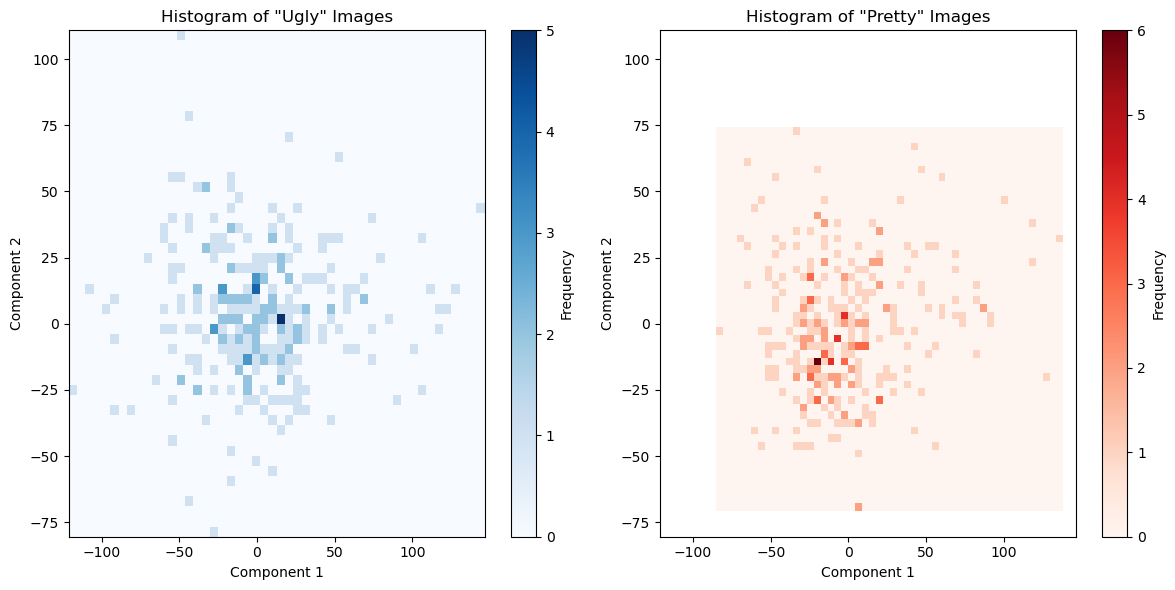

In [15]:
ugly_idx = test_scores < 0.5
pretty_idx = test_scores > 0.5

ugly_img = embeds_pca[ugly_idx]
pretty_img = embeds_pca[pretty_idx]

plt.figure(figsize=(12, 6))

# Plotting the histogram for "ugly" images
plt.subplot(1, 2, 1)
plt.hist2d(ugly_img[:, 0], ugly_img[:, 1], bins=50, cmap='Blues')
plt.colorbar(label='Frequency')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Histogram of "Ugly" Images')
plt.xlim(np.min(embeds_pca[:, 0]), np.max(embeds_pca[:, 0]))
plt.ylim(np.min(embeds_pca[:, 1]), np.max(embeds_pca[:, 1]))

# Plotting the histogram for "pretty" images
plt.subplot(1, 2, 2)
plt.hist2d(pretty_img[:, 0], pretty_img[:, 1], bins=50, cmap='Reds')
plt.colorbar(label='Frequency')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Histogram of "Pretty" Images')
plt.xlim(np.min(embeds_pca[:, 0]), np.max(embeds_pca[:, 0]))
plt.ylim(np.min(embeds_pca[:, 1]), np.max(embeds_pca[:, 1]))

plt.tight_layout()
plt.show()

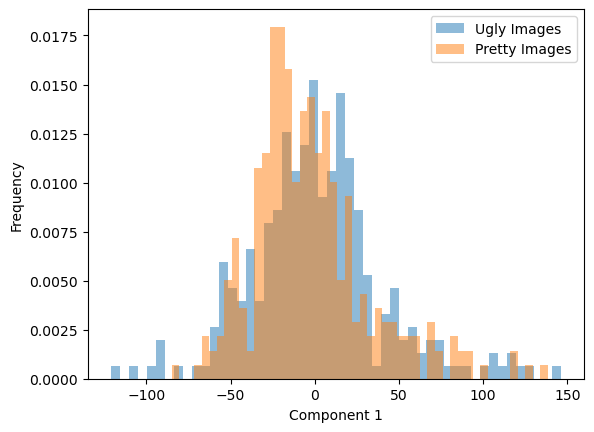

In [16]:
plt.hist(ugly_img[:, 0], density=True, bins=50, alpha=0.5, label='Ugly Images')
plt.hist(pretty_img[:, 0], density=True, bins=50, alpha=0.5, label='Pretty Images')
plt.xlabel('Component 1')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

pretty_idx = scores > 0.5

# Split the data into train and test sets
embeds = rearrange(n_latents, 'b c w h -> b (c w h)')
X_train, X_test, y_train, y_test = train_test_split(embeds, pretty_idx, test_size=0.2, random_state=42)

# Create a logistic regression classifier
classifier = LogisticRegression(max_iter=1000)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5286144578313253


It seems that also the Unet embeddings do not represent the difference between ugly and pretty images in an explicit way.

## Change the prompt

In [22]:
import torch
from PIL import Image

import matplotlib.pyplot as plt
from diffusers import StableDiffusionImg2ImgPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\mgphy\Anaconda3\envs\genai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


In [33]:
init_image = Image.open('dataset/data/datasetImages_originalSize/datasetImages_originalSize/farm1_255_19452343093_8ee7e5e375_b.jpg').convert("RGB")

prompt = "Two butterflies are perched on a plant, one on the left and the other on the right. Professional photographer."

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images

100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


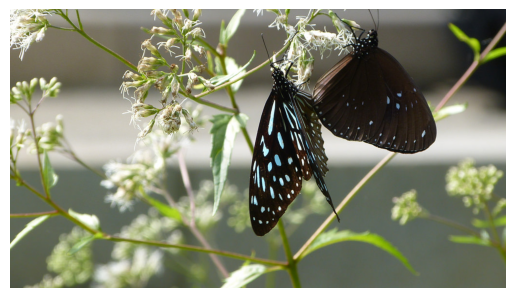

In [25]:
plt.imshow(init_image)
plt.axis('off')
plt.show()

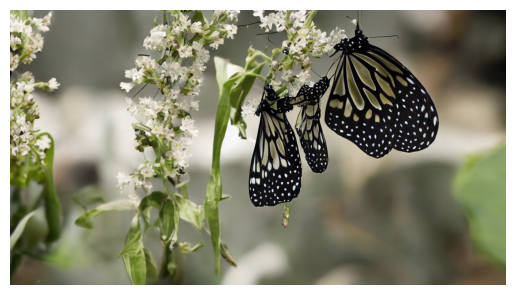

In [34]:
for image in images:
    plt.imshow(image)
    plt.axis('off')
    plt.show()